# Exploring all data from a tissue

This tutorial provides a series of examples for how to explore and query the Census in the context of a single tissue, lung. We will summarize cell and gene metadata, then fetch the single-cell expression counts and perform some basic data explorations via [Scanpy](https://scanpy.readthedocs.io/en/stable/) 


**Contents**

1. Learning about the human lung data.
   1. Learning about cells of the lung.
   2. Learning about genes of the lung .
2. Fetching all single-cell human lung data from the Census.
3. Calculating QC metrics of the lung data.
4. Creating a normalized expression layer and embeddings.


## Learning about the lung data in the Census

First we will open the Census. If you are not familiar with the basics of the Census API you should take a look at notebook [Learning about the CZ CELLxGENE Census](https://cellxgene-census.readthedocs.io/en/latest/notebooks/analysis_demo/comp_bio_census_info.html)


In [1]:
import cellxgene_census
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

census = cellxgene_census.open_soma()

Let's first take a look at the number of cells from human lung:


In [2]:
summary_table = census["census_info"]["summary_cell_counts"].read().concat().to_pandas()

summary_table.query("organism == 'Homo sapiens' & category == 'tissue_general' & label =='lung'")

,soma_joinid,organism,category,ontology_term_id,unique_cell_count,total_cell_count,label
944,944,Homo sapiens,tissue_general,UBERON:0002048,2295237,4573212,lung


There you can see the total of cells of under `total_cell_count` and the unique number cells under `unique_cell_count` (i.e. after removing cells that were included in multiple datasets).

Let's now take a look at the cell and gene information of this slice of the Census.

### Learning about cells of lung data

Let's load the cell metadata for all lung cells and select only the unique cells using `is_primary_data`.


In [3]:
lung_obs = (
    census["census_data"]["homo_sapiens"]
    .obs.read(value_filter="tissue_general == 'lung' and is_primary_data == True")
    .concat()
    .to_pandas()
)
lung_obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,is_primary_data,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id
0,145215,d8da613f-e681-4c69-b463-e94f5e66847f,10x 3' v3,EFO:0009922,lung ciliated cell,CL:1000271,70-year-old human stage,HsapDv:0000164,normal,PATO:0000461,...,True,European,HANCESTRO:0005,female,PATO:0000383,nucleus,lung,UBERON:0002048,lung,UBERON:0002048
1,145216,d8da613f-e681-4c69-b463-e94f5e66847f,10x 3' v3,EFO:0009922,alveolar macrophage,CL:0000583,70-year-old human stage,HsapDv:0000164,normal,PATO:0000461,...,True,European,HANCESTRO:0005,female,PATO:0000383,nucleus,lung,UBERON:0002048,lung,UBERON:0002048
2,145217,d8da613f-e681-4c69-b463-e94f5e66847f,10x 3' v3,EFO:0009922,lung ciliated cell,CL:1000271,70-year-old human stage,HsapDv:0000164,normal,PATO:0000461,...,True,European,HANCESTRO:0005,female,PATO:0000383,nucleus,lung,UBERON:0002048,lung,UBERON:0002048
3,145218,d8da613f-e681-4c69-b463-e94f5e66847f,10x 3' v3,EFO:0009922,lung ciliated cell,CL:1000271,70-year-old human stage,HsapDv:0000164,normal,PATO:0000461,...,True,European,HANCESTRO:0005,female,PATO:0000383,nucleus,lung,UBERON:0002048,lung,UBERON:0002048
4,145219,d8da613f-e681-4c69-b463-e94f5e66847f,10x 3' v3,EFO:0009922,lung ciliated cell,CL:1000271,70-year-old human stage,HsapDv:0000164,normal,PATO:0000461,...,True,European,HANCESTRO:0005,female,PATO:0000383,nucleus,lung,UBERON:0002048,lung,UBERON:0002048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295232,45561670,f64e1be1-de15-4d27-8da4-82225cd4c035,10x 3' v3,EFO:0009922,T cell,CL:0000084,78-year-old human stage,HsapDv:0000172,lung adenocarcinoma,MONDO:0005061,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
2295233,45562154,f64e1be1-de15-4d27-8da4-82225cd4c035,10x 3' v2,EFO:0009899,T cell,CL:0000084,67-year-old human stage,HsapDv:0000161,lung adenocarcinoma,MONDO:0005061,...,True,European,HANCESTRO:0005,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
2295234,45565290,f64e1be1-de15-4d27-8da4-82225cd4c035,10x 3' v2,EFO:0009899,T cell,CL:0000084,65-year-old human stage,HsapDv:0000159,lung adenocarcinoma,MONDO:0005061,...,True,European,HANCESTRO:0005,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
2295235,45566613,f64e1be1-de15-4d27-8da4-82225cd4c035,10x 3' v2,EFO:0009899,T cell,CL:0000084,80-year-old human stage,HsapDv:0000206,lung adenocarcinoma,MONDO:0005061,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048


You can see that the number or rows represents the total number of unique lung cells in the Census. Now let's take a deeper dive into the characteristics of these cells.

#### Datasets

First let's start by looking at what are the datasets and collections from [CELLxGENE Discover](https://cellxgene.cziscience.com/collections) contributing to lung. For this we will use the dataset table at `census["census-info"]["datasets"]` that contains metadata of all datasets used to build this Census.


In [4]:
census_datasets = (
    census["census_info"]["datasets"]
    .read(column_names=["collection_name", "dataset_title", "dataset_id", "soma_joinid"])
    .concat()
    .to_pandas()
)
census_datasets = census_datasets.set_index("dataset_id")
census_datasets

,collection_name,dataset_title,soma_joinid
dataset_id,,,
f512b8b6-369d-4a85-a695-116e0806857f,Transcriptional Programming of Normal and Infl...,Skin,0
36c867a7-be10-4e69-9b39-5de12b0af6da,Single-Cell Analysis of Crohn’s Disease Lesion...,Ileum,1
58b01044-c5e5-4b0f-8a2d-6ebf951e01ff,Humoral immunity at the brain borders in homeo...,A scRNA-seq atlas of immune cells at the CNS b...,2
456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,Single-cell atlas of peripheral immune respons...,3
d8da613f-e681-4c69-b463-e94f5e66847f,A molecular single-cell lung atlas of lethal C...,A molecular single-cell lung atlas of lethal C...,4
...,...,...,...
30498543-4fdd-4f86-9e1b-05c1a1454a6a,COVID-19 mRNA vaccine elicits a potent adaptiv...,"B cells -- CV19 infection, vaccination and HC",524
b5191f01-f67d-44b8-bc8d-511a4ecd07bb,COVID-19 mRNA vaccine elicits a potent adaptiv...,"innate T cells -- CV19 infection, vaccination ...",525
e463dae9-3fc1-476d-870e-d98a04c56cd6,COVID-19 mRNA vaccine elicits a potent adaptiv...,"M cells -- CV19 infection, vaccination and HC",526


The `obs` cell metadata `pandas.DataFrame` contains a column `dataset_id` that can be used for joining to the `census_dataset` `pandas.DataFrame` we just created.

So let's take a look at the cell counts per `dataset_id` of the lung slice and then join to the dataset table to append the human-readable labels.


In [5]:
dataset_cell_counts = pd.DataFrame(lung_obs[["dataset_id"]].value_counts())
dataset_cell_counts = dataset_cell_counts.rename(columns={0: "cell_counts"})
dataset_cell_counts = dataset_cell_counts.merge(census_datasets, on="dataset_id")

dataset_cell_counts

,count,collection_name,dataset_title,soma_joinid
dataset_id,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,157
066943a2-fdac-4b29-b348-40cede398e4e,254931,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,79
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,94
d8da613f-e681-4c69-b463-e94f5e66847f,116313,A molecular single-cell lung atlas of lethal C...,A molecular single-cell lung atlas of lethal C...,4
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,519
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,75
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",177
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,317
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,63


These are all the datasets lung cells whose counts are reprensented in the column `cell_counts`. The top collections with lung data are:

1. [The integrated Human Lung Cell Atlas](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293).
2. [A human cell atlas of fetal gene expression](https://cellxgene.cziscience.com/collections/c114c20f-1ef4-49a5-9c2e-d965787fb90c).
3. [High-resolution single-cell atlas reveals diversity and plasticity of tumor-associated neutrophils in non-small cell lung cancer](https://cellxgene.cziscience.com/collections/edb893ee-4066-4128-9aec-5eb2b03f8287).
4. [HTAN MSK - Single cell profiling reveals novel tumor and myeloid subpopulations in small cell lung cancer](https://cellxgene.cziscience.com/collections/62e8f058-9c37-48bc-9200-e767f318a8ec).
5. [A human fetal lung cell atlas uncovers proximal-distal gradients of differentiation and key regulators of epithelial fates.](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028).

#### Assays

Let's use similar logic to take a look at all the assays available for human lung data. This tells us that most assays are from 10x technologies and sci-RNA-seq.


In [6]:
lung_obs[["assay"]].value_counts()

assay                                   
10x 3' v2                                   1087211
10x 3' v3                                    436291
10x 5' v1                                    218556
sci-RNA-seq                                  217738
BD Rhapsody Whole Transcriptome Analysis     122902
single cell library construction              58981
10x 5' v2                                     45798
microwell-seq                                 33698
Smart-seq2                                    25662
inDrop                                        25652
10x 3' v1                                     11558
Drop-seq                                       7333
10x 3' transcription profiling                 3857
Name: count, dtype: int64

#### Disease

And now let's take a look at diseased cell counts, with `normal` indicating non-diseased cells.


In [7]:
lung_obs[["disease"]].value_counts()

disease                              
normal                                   1111566
lung adenocarcinoma                       626322
squamous cell lung carcinoma              189044
COVID-19                                  128650
non-small cell lung carcinoma             120796
chronic obstructive pulmonary disease      55254
pulmonary emphysema                        32065
small cell lung carcinoma                  31540
Name: count, dtype: int64

#### Sex

There doesn't seem to be strong biases for sex.


In [8]:
lung_obs[["sex"]].value_counts()

sex    
male       1267756
female     1019958
unknown       7523
Name: count, dtype: int64

#### Cell vs nucleus

The majority of data are from cells and not nucleus.


In [9]:
lung_obs[["suspension_type"]].value_counts()

suspension_type
cell               1879402
nucleus             415835
Name: count, dtype: int64

#### Cell types

Let's take a look at the counts of the top 20 cell types.


In [10]:
lung_obs[["cell_type"]].value_counts().head(20)

cell_type                                 
alveolar macrophage                           244502
CD4-positive, alpha-beta T cell               185787
macrophage                                    154415
CD8-positive, alpha-beta T cell               152746
type II pneumocyte                            143252
epithelial cell of lower respiratory tract    101959
classical monocyte                             90969
natural killer cell                            90715
stromal cell                                   87587
malignant cell                                 75917
B cell                                         61804
T cell                                         53703
fibroblast                                     41934
plasma cell                                    41907
fibroblast of lung                             41294
epithelial cell of lung                        38426
epithelial cell                                37498
regulatory T cell                              36381
mes

#### Sub-tissues

We can look at the original tissue annotations that were mapped to "lung".


In [11]:
lung_obs[["tissue"]].value_counts()

tissue                 
lung                       1882088
lung parenchyma             311950
alveolus of lung             54856
lingula of left lung         35284
lower lobe of left lung      11059
Name: count, dtype: int64

### Learning about genes of lung data

Let's load the gene metadata of the Census.


In [12]:
lung_var = census["census_data"]["homo_sapiens"].ms["RNA"].var.read().concat().to_pandas()
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000238009,RP11-34P13.7,3726
1,1,ENSG00000279457,WASH9P,1397
2,2,ENSG00000228463,AP006222.1,8224
3,3,ENSG00000237094,RP4-669L17.4,6204
4,4,ENSG00000230021,RP11-206L10.17,5495
...,...,...,...,...
60659,60659,ENSG00000288719,RP4-669P10.21,4252
60660,60660,ENSG00000288720,RP11-852E15.3,7007
60661,60661,ENSG00000288721,RP5-973N23.5,7765
60662,60662,ENSG00000288723,RP11-553N16.6,1015


You can see the total number of genes represented by the number of rows. This number is actually misleading because it is the join of all genes in the Census. However we know that the lung data comes from a subset of datasets.

So let's take a look at the number of genes that were measured in each of those datasets.

To accomplish this we can use the "dataset presence matrix" at `census["census_data"]["homo_sapiens"].ms["RNA"]["feature_dataset_presence_matrix"]`. This is a boolean matrix `N x M` where `N` is the number of datasets and `M` is the number of genes in the Census.

So we can select the rows corresponding to the lung datasets and perform a row-wise sum.


In [13]:
presence_matrix = cellxgene_census.get_presence_matrix(census, "Homo sapiens", "RNA")
presence_matrix = presence_matrix[dataset_cell_counts.soma_joinid, :]

In [14]:
presence_matrix.sum(axis=1).A1

array([17811, 28024, 44150, 34265, 22447, 26347, 20921, 24672, 27705,
       27243, 26323, 27181, 23203, 57030, 32610, 29620, 26454, 23705,
       38676, 47307, 21641, 23740, 22552, 20594, 19952], dtype=uint64)

In [15]:
genes_measured = presence_matrix.sum(axis=1).A1
dataset_cell_counts["genes_measured"] = genes_measured
dataset_cell_counts

,count,collection_name,dataset_title,soma_joinid,genes_measured
dataset_id,,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,157,17811
066943a2-fdac-4b29-b348-40cede398e4e,254931,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,79,28024
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,94,44150
d8da613f-e681-4c69-b463-e94f5e66847f,116313,A molecular single-cell lung atlas of lethal C...,A molecular single-cell lung atlas of lethal C...,4,34265
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,519,22447
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,75,26347
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",177,20921
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,317,24672
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,63,27705


You can see the genes measured in each dataset represented in `genes_measured`. Now lets get the **genes that were measured in all datasets**.


In [16]:
var_somaid = np.nonzero(presence_matrix.sum(axis=0).A1 == presence_matrix.shape[0])[0].tolist()

In [17]:
lung_var = lung_var.query(f"soma_joinid in {var_somaid}")
lung_var

,soma_joinid,feature_id,feature_name,feature_length
6,6,ENSG00000177757,FAM87B,1947
8,8,ENSG00000230368,FAM41C,1971
10,10,ENSG00000187634,SAMD11,4172
11,11,ENSG00000188976,NOC2L,5540
12,12,ENSG00000187961,KLHL17,3402
...,...,...,...,...
27743,27743,ENSG00000160838,LRRC71,2649
30433,30433,ENSG00000136918,WDR38,1387
30816,30816,ENSG00000149021,SCGB1A1,584
31272,31272,ENSG00000187848,P2RX2,1975


The number of rows represents the genes that were measured in all lung datasets.

### Summary of lung metadata

In the previous sections, using the Census we learned the following information:

- The total number of unique lung cells and their composition for:
  - Number of datasets.
  - Number sequencing technologies, most of which are 10x
  - Mostly human data, but some diseases exist, primarily "lung adenocarcinoma" and "COVID-19 infected"
  - No sex biases.
  - Mostly data from cells (\~80%) rather than nucleus (\~20%)
- A total of **~12k** genes were measured across all cells.

##  Fetching all single-cell human lung data from the Census

Since loading the entire lung data is resource-intensive, for the sake of this exercise let's load a subset of the lung data into an `anndata.AnnData` object and perform some exploratory analysis. 

We will subset to 100,000 random unique cells using the `lung_obs` `pandas.DataFrame` we previously created.

In [18]:
lung_cell_subsampled_n = 100000
lung_cell_subsampled_ids = lung_obs["soma_joinid"].sample(lung_cell_subsampled_n, random_state=1).tolist()

Now we can directly use the values of `soma_joinid` for querying the Census data and obtaining an `AnnData` object.

In [19]:
lung_gene_ids = lung_var["soma_joinid"].to_numpy()
lung_adata = cellxgene_census.get_anndata(
    census,
    organism="Homo sapiens",
    obs_coords=lung_cell_subsampled_ids,
    var_coords=lung_gene_ids,
)

lung_adata.var_names = lung_adata.var["feature_name"]

In [20]:
lung_adata

AnnData object with n_obs × n_vars = 100000 × 11516
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

We are done with the census, so close it

In [21]:
census.close()
del census

## Calculating QC metrics of the lung data

Now let's take a look at some QC metrics

**Top genes per cell**


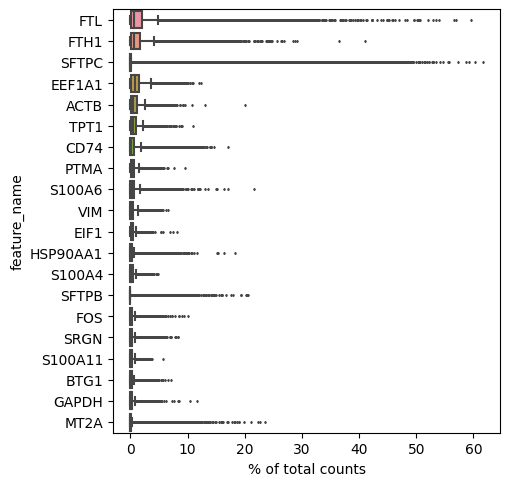

In [22]:
sc.pl.highest_expr_genes(lung_adata, n_top=20)

**Number of sequenced genes by assay**


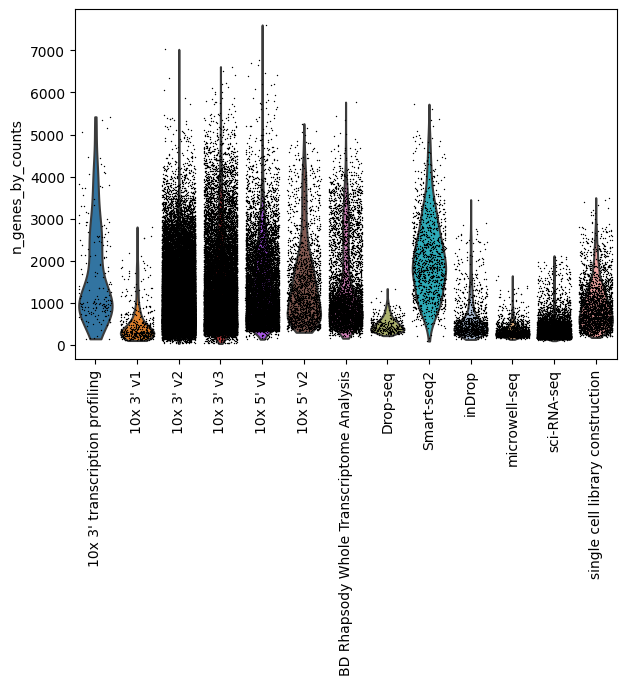

In [23]:
sc.pp.calculate_qc_metrics(lung_adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(lung_adata, "n_genes_by_counts", groupby="assay", jitter=0.4, rotation=90)

**Total counts by assay**


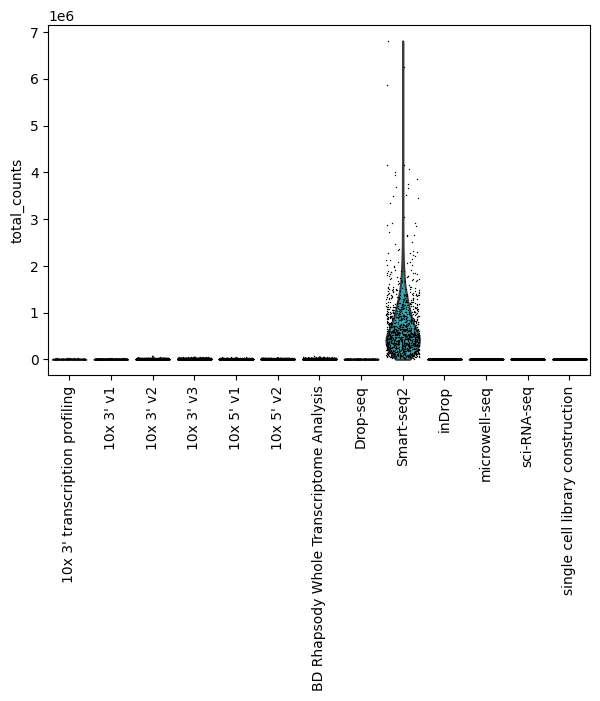

In [24]:
sc.pl.violin(lung_adata, "total_counts", groupby="assay", jitter=0.4, rotation=90)

You can see that Smart-Seq2 is an outlier for the total counts per cell, so let's exlcude it to see how the rest of the assays look like


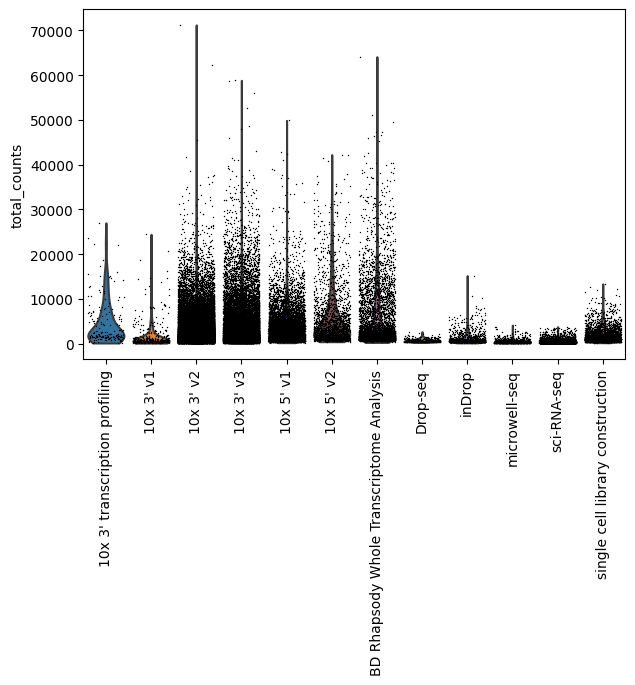

In [25]:
sc.pl.violin(
    lung_adata[lung_adata.obs["assay"] != "Smart-seq2",],
    "total_counts",
    groupby="assay",
    jitter=0.4,
    rotation=90,
)

## Creating a normalized expression layer and embeddings

Let's perform a bread and butter normalization and take a look at UMAP embeddings, but for all the data below we'll exclude Smart-seq2 as this requires an extra step to normalize based on gene lengths


In [26]:
lung_adata = lung_adata[lung_adata.obs["assay"] != "Smart-seq2",].copy()
lung_adata.layers["counts"] = lung_adata.X

Now let's do some basic normalization:

- Normalize by sequencing depth
- Transform to log-scale
- Select 500 highly variable genes
- Scale values across the gene axis


In [27]:
sc.pp.normalize_total(lung_adata, target_sum=1e4)
sc.pp.log1p(lung_adata)
sc.pp.highly_variable_genes(lung_adata, n_top_genes=500, flavor="seurat_v3", layer="counts")
lung_adata = lung_adata[:, lung_adata.var.highly_variable]
sc.pp.scale(lung_adata, max_value=10)

/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


And reduce dimensionality by obtaining UMAP embeddings.


In [28]:
sc.tl.pca(lung_adata)
sc.pp.neighbors(lung_adata)
sc.tl.umap(lung_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


And plot these embeddings.


In [29]:
n_cell_types = len(lung_adata.obs["cell_type"].drop_duplicates())

from random import randint

colors = []

for i in range(len(lung_adata.obs["cell_type"].drop_duplicates())):
    colors.append("#%06X" % randint(0, 0xFFFFFF))

/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


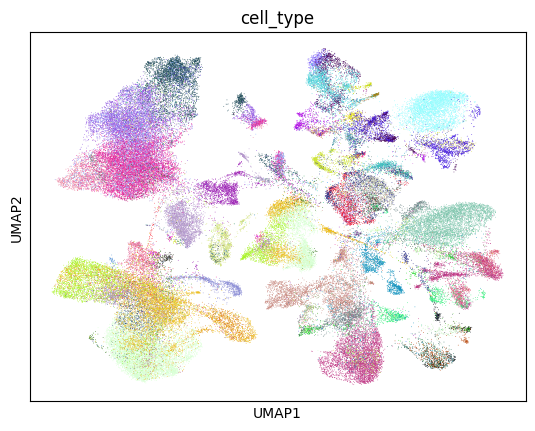

In [30]:
sc.pl.umap(lung_adata, color="cell_type", palette=colors, legend_loc=None)

Let's color by assay.


/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


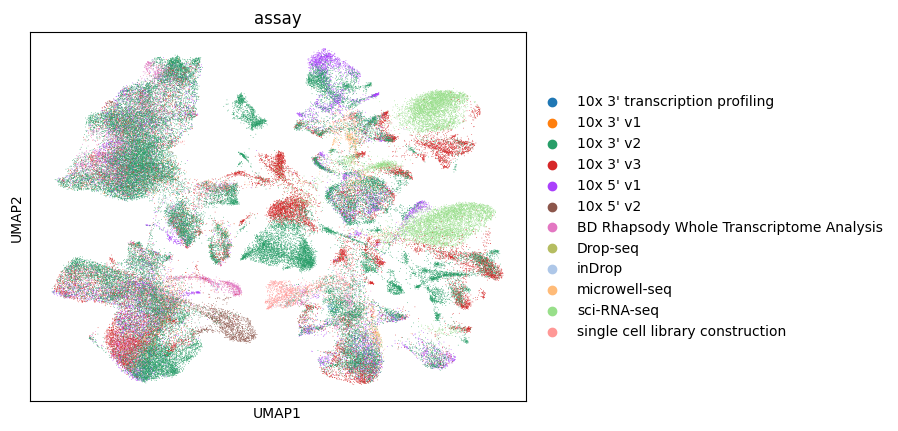

In [31]:
sc.pl.umap(lung_adata, color="assay")

Given the high number of cell types it makes it hard to visualize, so let's look at the top 20 most abundant cell types.


In [32]:
top_cell_types = lung_adata.obs["cell_type"].value_counts()
top_cell_types = list(top_cell_types.reset_index().head(20)["cell_type"])

/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


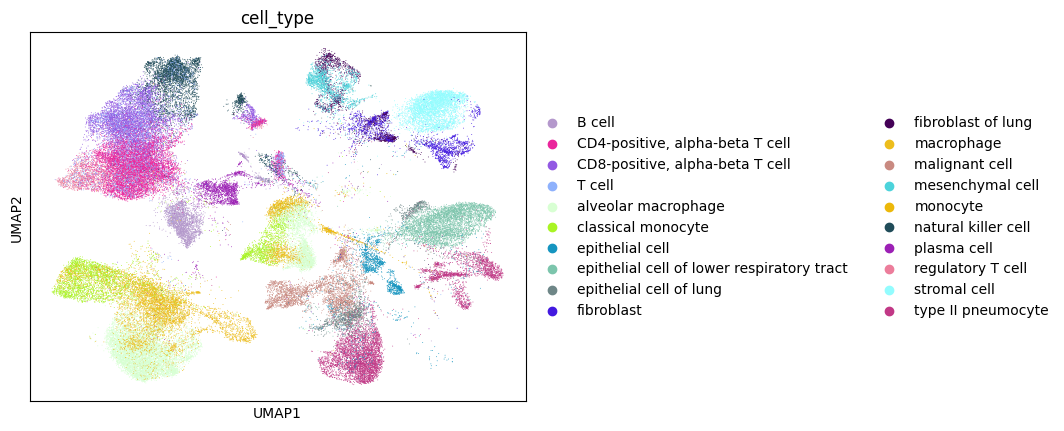

In [33]:
lung_adata_top_cell_types = lung_adata[[i in top_cell_types for i in lung_adata.obs["cell_type"]], :]
sc.pl.umap(lung_adata_top_cell_types, color="cell_type")

Let's color by assay of this subset of the data.


/Users/pgarcianieto/opt/miniconda3/envs/census_latest/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


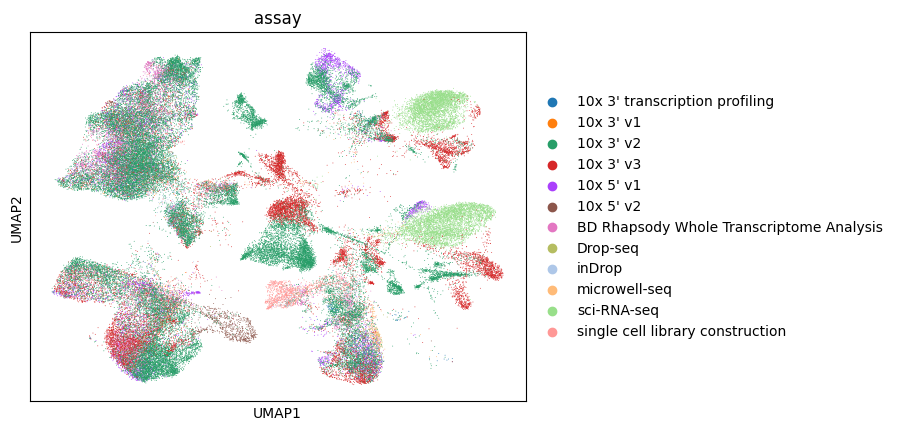

In [34]:
sc.pl.umap(lung_adata_top_cell_types, color="assay")